# House Price Prediction

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

# Loading Dataset

In [15]:
df=pd.read_csv("housing.csv")
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


# Basic Info

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# Statistical Analysis

In [82]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.573663,1425.476744,499.539680,3.870671,206855.816909,1.165843,5.429000,0.213047,3.070655
std,2.003532,2.135952,12.585558,2181.615252,420.411735,1132.462122,382.329753,1.899822,115395.615874,1.420662,2.474173,0.057879,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,0.000000,4.440716,0.175482,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,1.000000,5.229129,0.203201,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,1.000000,6.052381,0.239828,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,4.000000,141.909091,1.000000,1243.333333


# Missing Values  

In [23]:
print(df.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


# Handling Missing Values

In [27]:
def impute_knn(df):
    ldf = df.select_dtypes(include=[np.number])
    ldf_putaside = df.select_dtypes(exclude=[np.number])
    cols_nan = ldf.columns[ldf.isna().any()].tolist()
    cols_no_nan = ldf.columns.difference(cols_nan).values

    for col in cols_nan:
        imp_test = ldf[ldf[col].isna()]
        imp_train = ldf.dropna()
        model = KNeighborsRegressor(n_neighbors=5)
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ldf.loc[df[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ldf, ldf_putaside], axis=1)

df = impute_knn(df)


# Encoding Categorical Values

In [37]:
label_encoder = LabelEncoder()
df['ocean_proximity'] = label_encoder.fit_transform(df['ocean_proximity'])


# Visualizations

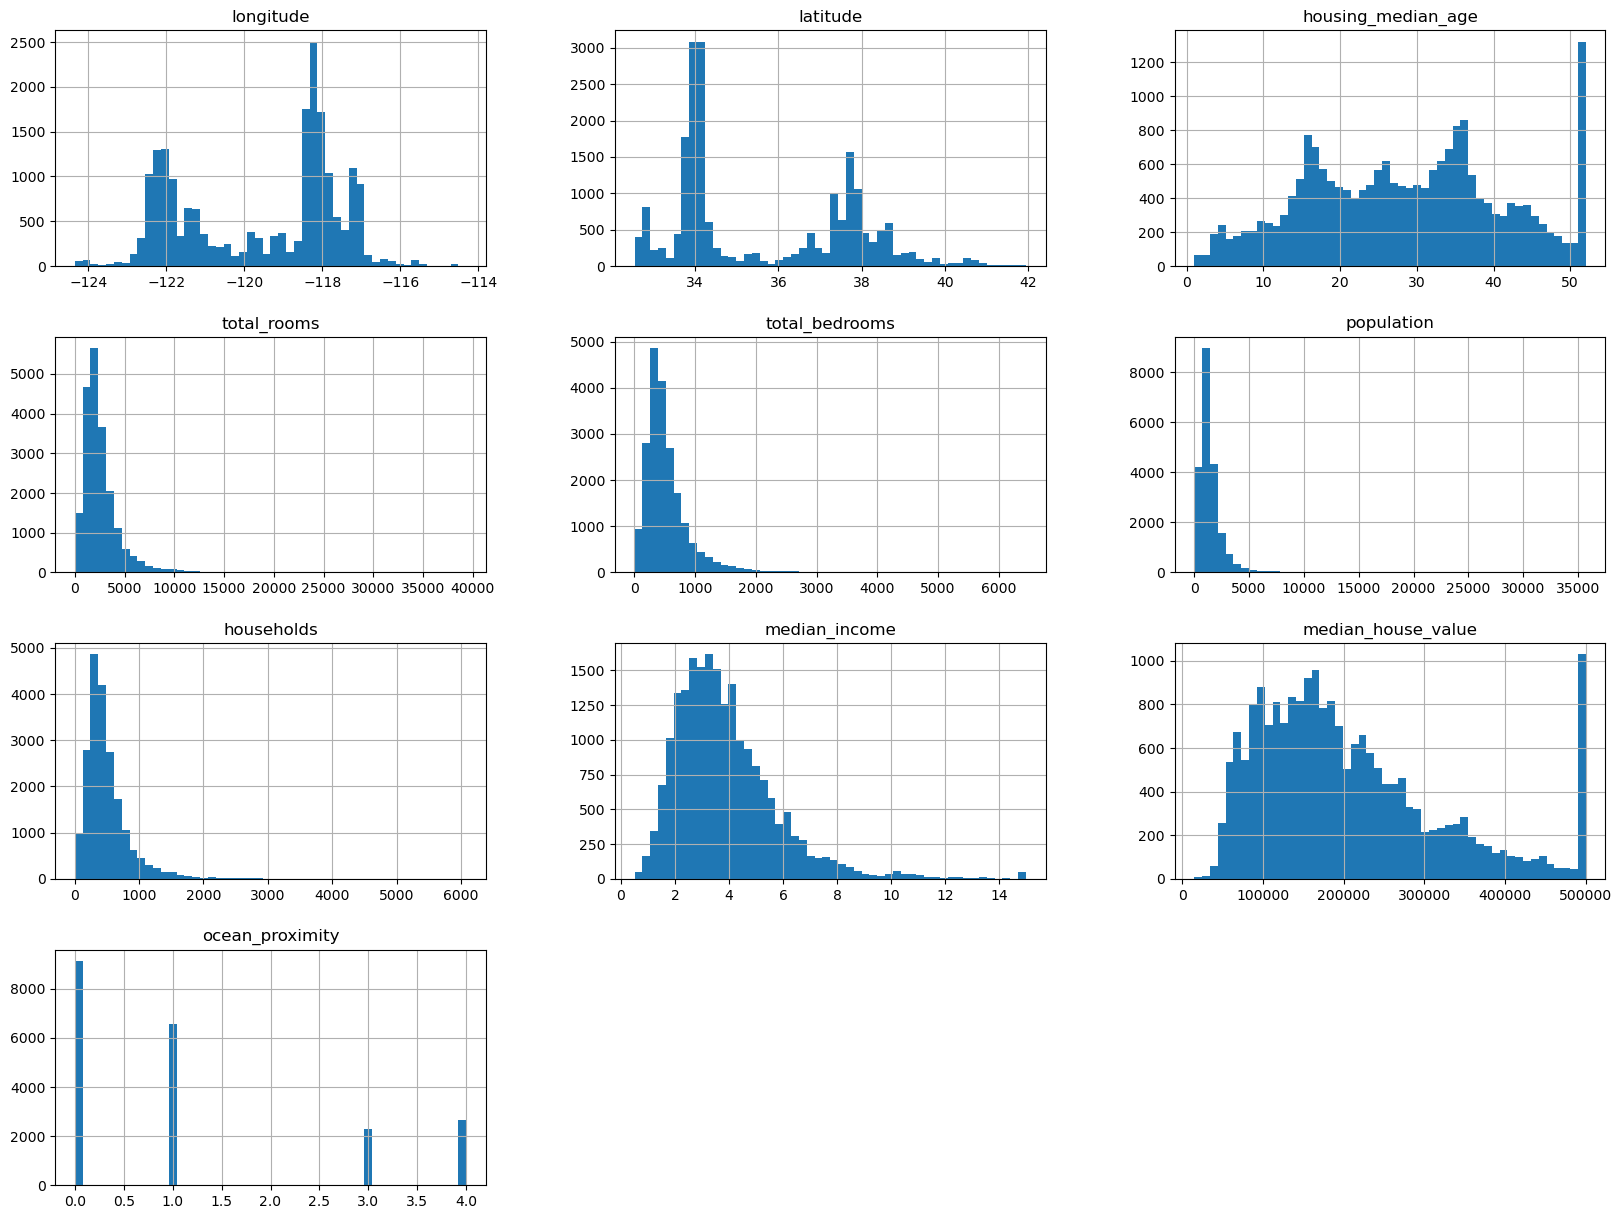

In [41]:
df.hist(bins=50, figsize=(20, 15))
plt.show()


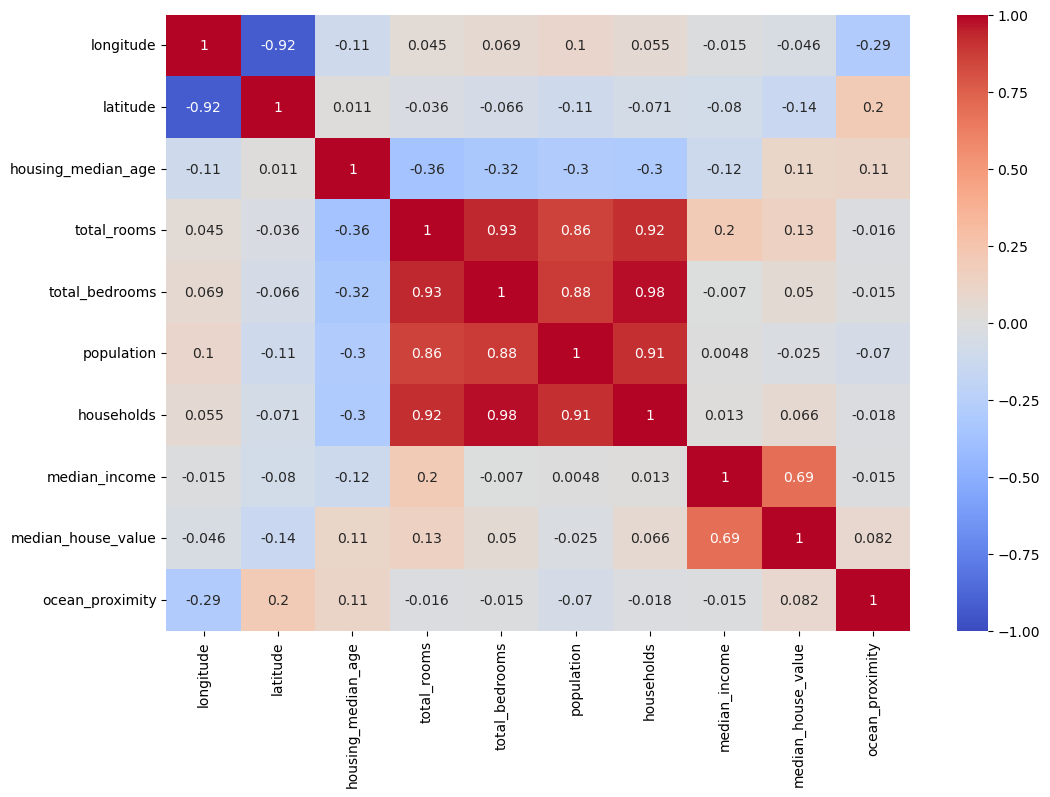

In [42]:
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


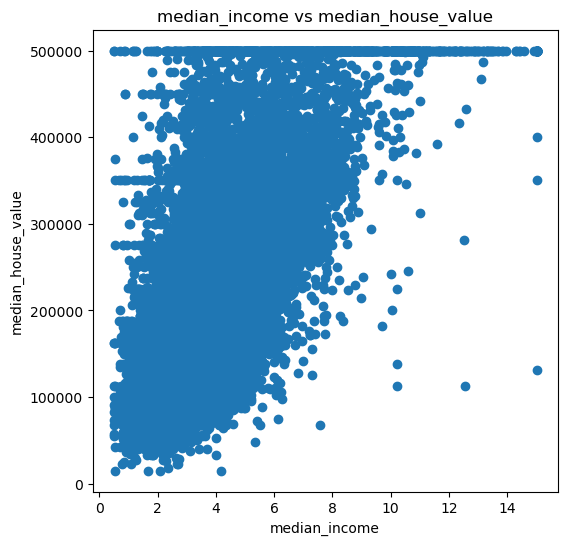

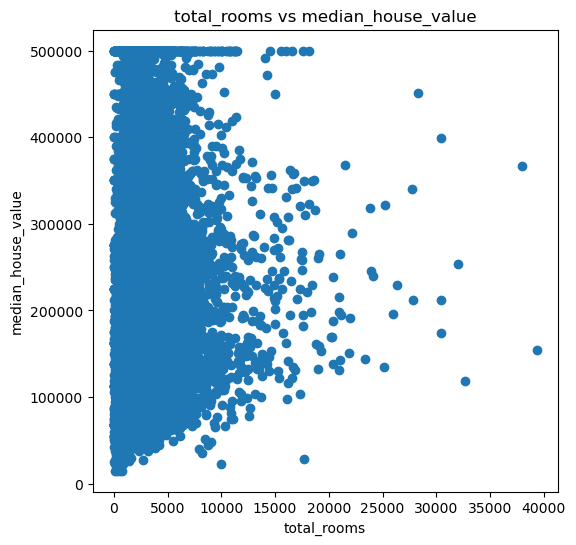

In [43]:
def plot_feature_vs_target(df, feature, target='median_house_value'):
    plt.figure(figsize=(6, 6))
    plt.scatter(df[feature], df[target])
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.title(f'{feature} vs {target}')
    plt.show()

plot_feature_vs_target(df, 'median_income')
plot_feature_vs_target(df, 'total_rooms')


# Feature Analysis

In [45]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']


# Training Data

In [53]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

X_train = train_data.drop('median_house_value', axis=1)
y_train = train_data['median_house_value']
X_test = test_data.drop('median_house_value', axis=1)
y_test = test_data['median_house_value']


# Actual Vs Predicted  Price

In [64]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = LinearRegression() # building the model
model.fit(X_train, y_train)
predictions = model.predict(X_test) # making predictions

comparison_df = pd.DataFrame({ # creating a DataFrame to compare actual and predicted values
    'Actual': y_test,
    'Predicted': predictions
})

print(comparison_df.head(10))


         Actual      Predicted
20046   47700.0   58449.913397
3024    45800.0  155413.901219
15663  500001.0  311825.931936
20484  218600.0  286286.788908
9814   278000.0  251697.278214
13311  158700.0  200779.207781
7113   198200.0  267526.118559
7668   157500.0  199233.064215
18246  340000.0  279930.193778
5723   446600.0  397922.504235


# Model

In [57]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)# evaluating the model
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f'Training MSE: {mse_train:.2f}')
print(f'Training R²: {r2_train:.2f}')
print(f'Test MSE: {mse_test:.2f}')
print(f'Test R²: {r2_test:.2f}')


Training MSE: 4711311602.28
Training R²: 0.65
Test MSE: 4707709349.47
Test R²: 0.64


R², or R-squared, is a statistical measure that shows how well your model's predictions match the actual data. In simplest terms:
R² ranges from 0 to 1:
- 0 means the model doesn't explain any of the variability in the data (it’s as good as just guessing).
- 1 means the model perfectly explains all the variability in the data (it’s an ideal prediction).

- Higher R²: The model explains a large portion of the variance in the dependent variable. For example, an R² of 0.65 means your model explains 65% of the variability in the target variable.
- Lower R²: The model explains less of the variance. For example, an R² of 0.10 means your model only explains 10% of the variability.
In our case, an R² of 0.64 means your model is reasonably good, but there’s still 36% of the variance that it doesn’t capture.

# Regression Line

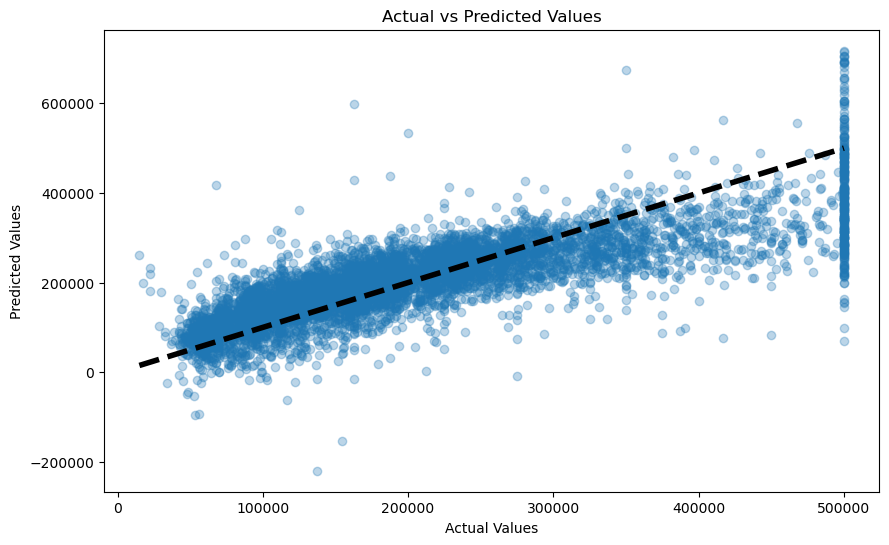

In [59]:

predictions = model.predict(X_test)
plt.figure(figsize=(10, 6)) # plot predictions vs actual values
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


# model’s R² values (0.64-0.65) indicate a moderate fit to the data. It explains about 64-65% of the variance in house prices, which is decent but leaves room for improvement. The MSE values suggest some prediction errors, but overall, the model seems to be reasonably effective. 